# Bundle adjustment 

General formulation: Given a set of images, reconstruct a 3D scene:
* Estimate feature in given images
* Find correspondences by matching the features

Given point correspondences estimate 3D location of the observed points + position ans orientation of the camera + camera internal parameters.

And do that such that the **reprojection error** (my version -- projection error, since there is only projection from 3D into 2D is involved) is minimized

$$ E = \sum_j\sum_i || y_{ij} - f(X_i, K_j, p_j) ||$$
where $y_{ij}$ - 2D pixel coordinate of feature i in camera j, $X_i$ - 3D coordinate of a point that should ideally be projected in $y_i$, $K_j$ - camera's j internal parameters, $p_j$ - external parameters of camera j (position and orientation).

To be robust against wrong correspondences put robust function \rho. Check Huber, McClure etc.:
$$E = \sum_j\sum_i \rho(|| y_{ij} - f(X_i, K_j, p_j)||)$$

In general, bundle adjustment is a maximum likelihood estimation problem. So, further is a simple example of solving the maximum likelihood problem.

### Fitting a line using maximum likelihood estimation
Given an array of 2D points fit the line.
Let's denote the points that we observe with $y_i$ and the function that generates points $f(x_i)$ and $e_i$ additive gaussian noise.
Then we have the following formulation $ yi = f(x_i) + e_i $.

Since we are fitting a line than $f(x_i|a,b) = ax_i + b$. We also want to maximize the likelihood of the observed data, given we select the parameters for $a,b$.
$$p(y_1..y_n|a,b) = \prod \frac{1}{\sqrt{2\pi\sigma^2}} \mathrm{exp}(-\frac{(y_i-f(x))^2}{2\sigma^2})$$
$$-log(p(y|a,b)) = \frac{1}{\sqrt{2\pi\sigma^2}} \sum_i-(-\frac{(y_i-f(x_i))^2}{2\sigma^2})$$
$$ min_{a,b} L(y| a,b) \propto \sum_i (y_i - ax_i -b)^2$$

**Regular solution **

Now we need to minimize L with respect to parameters (a,b). For that we take the derivative with respect to a and b and set it to zero.
$$\frac{\partial L}{\partial a} = \sum(y_i - ax_i -b)(-x_i)$$
$$\frac{\partial L}{\partial b} = \sum(y_i - ax_i -b)(-1)$$

After some manipulations we can get the system of linear equation.

$$
\begin{pmatrix}
    \sum x_i^2 & \sum x_i\\
    \sum x_i & N
\end{pmatrix}  
\begin{pmatrix}
    a\\
    b
\end{pmatrix} 
=
\begin{pmatrix}
    \sum y_ix_i \\
    \sum y_i
\end{pmatrix}
$$


** Elegant solution **

Consider $y = (y_1, .., y_n)$ be a vector and $x = [[x_1, 1], [x_2, 1], ..., [x_n, 1]]$ $nx2$ a matrix and $\theta = (a,b)^T$ line parameters. Then given the fact that we fit a line, we minimize the following likelihood $ L = || y - x\theta ||_{\sum_i} $. Taken into account gaussian noise assumption
$$L = (y-x\theta)^T \cdot (y-x\theta)$$
$$L = y^Ty - 2y^Tx\theta + \theta^Tx^Tx\theta $$
Then considering the fact that $(a^Ta)' = 2a$. the derivative over $\theta$ will have the following form
$$\frac{\partial L}{\partial\theta} = -2y^Tx \cdot 2x^Tx\theta$$ and $\theta = (x^Tx)^{-1}y^Tx$

In [55]:
import numpy as np
import matplotlib.pyplot as plt

def mlEstimation(x,y):
    x_sq = np.square(x)
    sum_x2 = np.sum(x_sq)

    sum_x = np.sum(x)
    sum_y = np.sum(y)

    sum_xy = np.dot(x,y)

    m = np.ndarray(shape=(2,2), dtype=float, order='F')
    m[0,0] = sum_x2
    m[0,1] = sum_x
    m[1,0] = sum_x
    m[1,1] = x.shape[0]

    b = np.array([sum_xy, sum_y])

    sol = np.linalg.solve(m, b)
    
    return sol


x = np.array([4.75, 5.30, 5.20, 2.75, 4.59, 1.20, 4.94, 0.22, 1.94, 0.32, 0.68, 5.76])
y = np.array([9.39, 9.95, 10.52, 5.27, 8.96, 3.15, 9.71, 1.69, 4.19, 1.74, 2.23, 11.22])

sol = mlEstimation(x,y)
print "ML estimate of (a,b) for original data", sol


x = np.append(x, 5.70)
y = np.append(y, 2.10)

sol_cont = mlEstimation(x,y)
print "ML estimate of (a,b) for contaminated data", sol_cont


ML estimate of (a,b) for original data [1.74090899 1.03956472]
ML estimate of (a,b) for contaminated data [1.37730457 1.57029592]


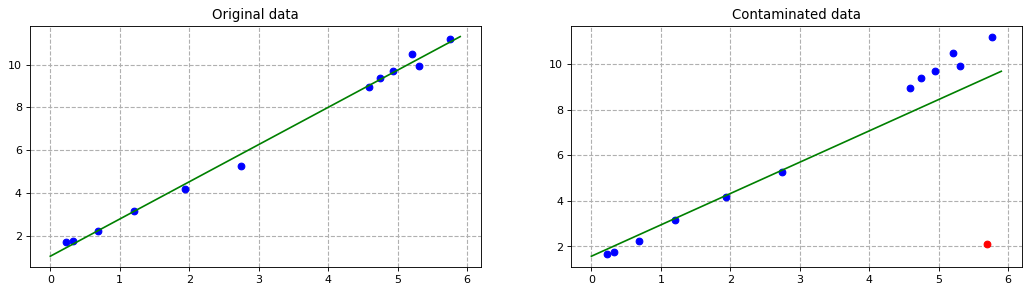

In [56]:
## plotting
fig=plt.figure(figsize=(16, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.plot(x[:-1],y[:-1], 'bo');
line = np.arange(0, 6, 0.1)

f = sol[0] * line + sol[1]
plt.plot(line, f, 'g-')

plt.grid(linestyle='--', linewidth=1);
plt.title("Original data");

plt.subplot(122)
plt.plot(x[:-1], y[:-1], 'bo');
plt.plot(x[-1], y[-1], 'ro');

f = sol_cont[0] * line + sol_cont[1]
plt.plot(line, f, 'g-')

plt.grid(linestyle='--', linewidth=1);
plt.title("Contaminated data");


To sum up, outliers influence the estimation of the parameters. And robust function should help against them, however the solution will be not be that simple any more.

MAP
How to add prior and make it a Bayesian estimation?